# Robustness to Image Translation

This notebook will demonstrate:
 - Setting up PyTorch training and testing experiments with hydra-zen and rai-toolbox
 - Configuring and running repeatable and scalable experiments with [hydra-zen](https://github.com/mit-ll-responsible-ai/hydra-zen)
 - Experimenting with robustness to image translations on MNIST


## Base Imports

In [1]:
%matplotlib inline

import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm

In [2]:
import xarray as xr
from hydra import compose, initialize
from hydra.core.config_store import ConfigStore

### Imports from MITLL packages

In [3]:
from hydra_zen import MISSING, builds, instantiate, launch, make_config
from rai_toolbox.mushin._tasks import RobustnessCurve

## Training and Testing Functions

### Setting Random Seed

This functions will allows us to set the random seed so we can repeat our experiments and get the same results.

In [4]:
def set_seed(random_seed) -> None:
    np.random.seed(random_seed)
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)

### Experiment Functions

#### Models

We will be testing a Fully Connected (FC) neural network and Convolutional Neural Network (CNN).

In [5]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 10, 3),
            nn.Flatten(1),
        )

    def forward(self, x):
        return self.model(x)


class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

### Tanslation Perturbation

We will use `torchvision.transforms.RandomAffine` to randomly translate the image in both dimensions of the image.  We define the perturbation equally in both height and width using a single parameter $\epsilon$. This choice of perturbations was made for simplicity and can be updated to support perturbations in each dimension seperately.

In [6]:
def translate_perturbation(data: Tensor, epsilon) -> Tensor:
    xform = transforms.RandomAffine(degrees=0.0, translate=(epsilon, epsilon))
    return xform(data)

### Training and Testing

We provide functions for training and testing of models.  Both functions support perturbing the data: for training this is data augmentation, for testing this is for evaluating sensitivity to perturbations.

In [7]:
def train_model(
    model,
    train_dataset,
    epsilon=0.0,
    num_epochs=10,
    batch_size=100,
    num_workers=4,
    device="cpu",
    learning_rate=0.1,
):
    dl = DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
    )

    nn_model = model["nn"]
    nn_model = nn_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)
    for i in tqdm(range(num_epochs)):
        nn_model.train()
        for data, target in dl:
            data = data.to(device)
            if epsilon > 0:
                data = translate_perturbation(data, epsilon)

            target = target.to(device)
            logit = nn_model(data)
            loss = criterion(logit, target)

            optim.zero_grad()
            loss.backward()
            optim.step()

    torch.save(nn_model.state_dict(), "model.ckpt")


def test_model(
    model, test_dataset, epsilon=0.0, batch_size=100, num_workers=4, device="cpu",
):
    assert model["ckpt"] is not None
    nn_model = model["nn"]
    nn_model.load_state_dict(torch.load(str(model["ckpt"])))
    nn_model = nn_model.to(device)

    test_dl = DataLoader(
        test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
    )

    preds = []
    with torch.no_grad():
        nn_model.eval()
        for tdata, ttarget in test_dl:
            tdata = tdata.to(device)
            ttarget = ttarget.to(device)

            if epsilon > 0:
                tdata = translate_perturbation(tdata, epsilon)

            tlogit = nn_model(tdata)

            # Save if prediction is correct or not for each sample
            preds.extend((tlogit.argmax(1) == ttarget).float().cpu().numpy())

    return sum(preds) / len(preds)

### Plotting

Just a helper function for plotting some results below.

In [8]:
def bar_chart(cnn_tests, fc_tests, aug_cnn_tests=None, aug_fc_tests=None):
    fig, ax = plt.subplots()

    cnn_no_translate = cnn_tests[0].return_value
    fc_no_translate = fc_tests[0].return_value

    cnn_translate = cnn_tests[1].return_value
    fc_translate = fc_tests[1].return_value

    if aug_cnn_tests is None:
        ax.bar(
            [0 - 0.25 / 2, 1 - 0.25 / 2],
            [fc_no_translate * 100, fc_translate * 100],
            width=0.25,
            label="FC",
        )
        ax.bar(
            [0 + 0.25 / 2, 1 + 0.25 / 2],
            [cnn_no_translate * 100, cnn_translate * 100],
            width=0.25,
            label="CNN",
        )
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Original Test Data", "Translated Test Data"])

    else:
        aug_cnn_no_translate = aug_cnn_tests[0].return_value
        aug_fc_no_translate = aug_fc_tests[0].return_value

        aug_cnn_translate = aug_cnn_tests[1].return_value
        aug_fc_translate = aug_fc_tests[1].return_value

        ax.bar(
            [0 - 0.25 / 2, 1 - 0.25 / 2, 2 - 0.25 / 2],
            [fc_no_translate * 100, fc_translate * 100, aug_fc_translate * 100],
            width=0.25,
            label="FC",
        )
        ax.bar(
            [0 + 0.25 / 2, 1 + 0.25 / 2, 2 + 0.25 / 2],
            [cnn_no_translate * 100, cnn_translate * 100, aug_cnn_translate * 100],
            width=0.25,
            label="CNN",
        )

        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(
            [
                "Original Test Data",
                "Translated Test Data",
                "Translated Test Data \n with Augmentations",
            ],
            rotation=30,
        )

    ax.set_ylabel("% Accuracy on Test Set")
    ax.legend()

## hydra-zen Configurations

In this section, we use hydra-zen (https://github.com/mit-ll-responsible-ai/hydra-zen) to create configurations for the datasets, models, and training that will be used in the experiments in this notebook.

In a nutshell, hydra-zen is a Python library that simplifies the process of writing code (research-grade or production-grade) that is:

  - **Configurable**: you can configure all aspects of your code from a single interface (the command line or a single Python function).
  - **Repeatable**: each run of your code will be self-documenting; the full configuration of your software is saved alongside your results.
  - **Scalable**: launch multiple runs of your software, be it on your local machine or across multiple nodes on a cluster.

hydra-zen builds off--and is fully compatible with--Hydra (https://hydra.cc/), a framework for elegantly configuring complex applications.

### Dataset

We use the standard PyTorch location for datasets in `HOME/.torch/data`. We also use the standard training and test splits for MNIST as provided by `torchvision.datasets.MNIST`.

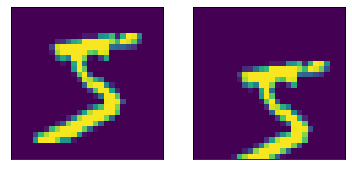

In [9]:
DATA_DIR = Path.home() / ".torch" / "data"
ToTensor = builds(transforms.ToTensor)
Dataset = builds(datasets.MNIST, root=DATA_DIR, train=True, transform=ToTensor)
TestDataset = builds(datasets.MNIST, root=DATA_DIR, train=False, transform=ToTensor)


# Test
dataset = instantiate(Dataset)
X, Y = dataset[0]
Xt = translate_perturbation(X, 0.3)

fig, ax = plt.subplots(ncols=2, subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(X[0])

ax[1].imshow(Xt[0])

### Models

In [10]:
_ConvModelCfg = builds(ConvModel)
_LinearModelCfg = builds(LinearModel)

ConvModelCfg = make_config(ckpt=None, nn=_ConvModelCfg)

LinearModelCfg = make_config(ckpt=None, nn=_LinearModelCfg)

# Test
dataset = instantiate(Dataset)
cnn = instantiate(ConvModelCfg)
fc = instantiate(LinearModelCfg)

X, Y = dataset[0]
assert cnn.nn(X[None]).shape == (1, 10)
assert fc.nn(X[None]).shape == (1, 10)

### Training and Testing Functions

In [11]:
Trainer = builds(
    train_model,
    populate_full_signature=True,
    train_dataset=Dataset,
    epsilon="${epsilon}",
    zen_partial=True,
)

Tester = builds(
    test_model,
    test_dataset=TestDataset,
    epsilon="${epsilon}",
    populate_full_signature=True,
    zen_partial=True,
)

### Make Swappable Configurations

We use Hydra's `ConfigStore` API to store configurations so that we can swap specific configurations from the command line.  Here we store the the two model configs so that we can easily swap training and testing with the CNN or the FC model.

In [12]:
cs = ConfigStore.instance()
cs.store(name="cnn", group="model", node=ConvModelCfg)
cs.store(name="fc", group="model", node=LinearModelCfg)

### Main Config

This is the main configuration for running experiments. The `defaults` parameters defines the configurations we plan to swap while providing a default value.  Here the default value is to train with the fully connected network, "fc", as defined in the `ConfigStore` above.

In [13]:
Config = make_config(
    defaults=["_self_", {"model": "fc"}],
    epsilon=0.0,
    model=MISSING,
    trainer=Trainer,
    tester=Tester,
)

# store the main config in the ConfigStore
cs.store(name="notebook_config", node=Config)

## Train Models

Here we define a training task for the CNN and FC models using a single GPU.  We take advantage of Hydra's `multirun` capability to automatically launch jobs for a given list of configuration overrides, e.g. `model=cnn,fc`.  The output is a class containing configurations of the each job and the return value provided by the task function below.

In [14]:
def train_task_fn(cfg):
    # important to set seed BEFORE instantiating any objects
    set_seed(42)

    # recursively instantiates all configurations
    obj = instantiate(cfg)
    return obj.trainer(obj.model)

In [15]:
(training_jobs,) = launch(
    Config,
    train_task_fn,
    overrides=["model=cnn,fc", "trainer.device=cuda"],
    multirun=True,
)

[2022-03-10 22:36:42,319][HYDRA] Launching 2 jobs locally
[2022-03-10 22:36:42,320][HYDRA] 	#0 : model=cnn trainer.device=cuda


  0%|          | 0/10 [00:00<?, ?it/s]

[2022-03-10 22:37:07,116][HYDRA] 	#1 : model=fc trainer.device=cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Now that we have trained models lets create new configs that contain the model checkpoints so we can easily use them in our robustness experiments below.

In [16]:
TrainedConvModelCfg = make_config(
    ckpt=Path(training_jobs[0].working_dir).absolute() / "model.ckpt",
    nn=_ConvModelCfg,
    hydra_convert="all",
)
TrainedLinearModelCfg = make_config(
    ckpt=Path(training_jobs[1].working_dir).absolute() / "model.ckpt",
    nn=_LinearModelCfg,
    hydra_convert="all",
)

cs.store(name="trained_cnn", group="model", node=TrainedConvModelCfg)
cs.store(name="trained_fc", group="model", node=TrainedLinearModelCfg)

## Test Models

Define the testing task and evalulate the models for varying levels of translation of the image.

In [17]:
def testing_task_fn(cfg):
    set_seed(42)
    obj = instantiate(cfg)
    return obj.tester(obj.model)

[2022-03-10 22:37:23,649][HYDRA] Launching 2 jobs locally
[2022-03-10 22:37:23,650][HYDRA] 	#0 : model=trained_cnn epsilon=0
[2022-03-10 22:37:24,680][HYDRA] 	#1 : model=trained_cnn epsilon=0.2
[2022-03-10 22:37:26,107][HYDRA] Launching 2 jobs locally
[2022-03-10 22:37:26,108][HYDRA] 	#0 : model=trained_fc epsilon=0
[2022-03-10 22:37:27,036][HYDRA] 	#1 : model=trained_fc epsilon=0.2


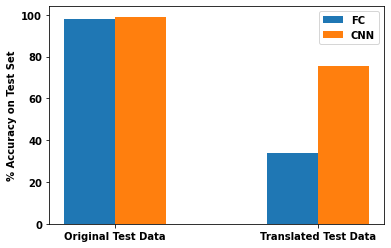

In [18]:
(cnn_tests,) = launch(
    Config,
    testing_task_fn,
    overrides=["model=trained_cnn", "epsilon=0,0.2"],
    multirun=True,
)

(fc_tests,) = launch(
    Config,
    testing_task_fn,
    overrides=["model=trained_fc", "epsilon=0,0.2"],
    multirun=True,
)

bar_chart(cnn_tests, fc_tests)

Here we introduce a specialized task, `rai_toolbox.mushin._tasks.RobustnessCurve`. This task allows us to launch jobs to create robustness curves, provide a [xarray.DataArray](https://docs.xarray.dev/en/stable/index.html) of the metrics, and a method to `plot` the curve.

In [19]:
class TranslationRobustness(RobustnessCurve):
    @staticmethod
    def evaluation_task(model, tester) -> torch.Tensor:
        set_seed(42)
        return tester(model)

First lets demonstrate executing this function on a single model to see how to initiate the task, execute `run`, and `plot` the results.

[2022-03-10 22:37:31,117][HYDRA] Launching 10 jobs locally
[2022-03-10 22:37:31,118][HYDRA] 	#0 : epsilon=0.0
[2022-03-10 22:37:32,070][HYDRA] 	#1 : epsilon=0.1
[2022-03-10 22:37:33,027][HYDRA] 	#2 : epsilon=0.2
[2022-03-10 22:37:34,109][HYDRA] 	#3 : epsilon=0.3
[2022-03-10 22:37:35,181][HYDRA] 	#4 : epsilon=0.4
[2022-03-10 22:37:36,157][HYDRA] 	#5 : epsilon=0.5
[2022-03-10 22:37:37,189][HYDRA] 	#6 : epsilon=0.6
[2022-03-10 22:37:38,370][HYDRA] 	#7 : epsilon=0.7000000000000001
[2022-03-10 22:37:39,429][HYDRA] 	#8 : epsilon=0.8
[2022-03-10 22:37:40,417][HYDRA] 	#9 : epsilon=0.9


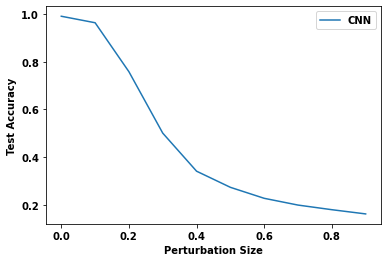

In [20]:
with initialize(config_path=None):
    cfg = compose("notebook_config", overrides=["model=trained_cnn"])

task = TranslationRobustness(cfg)
task.run(job_epsilons="range(0,1,0.1)", sweepdir="outputs/curve_cnn")
task.plot(save_fig=False, label="CNN")
plt.legend()

We can also convert the task data to an [xarray.DataArray](https://docs.xarray.dev/en/stable/index.html).  This will be useful when we produce results across multiple experiments.

In [21]:
xdata = task.to_xarray()
xdata.to_dataframe()

,accuracy
epsilon,
0.0,0.9910
0.1,0.9637
0.2,0.7581
0.3,0.5004
0.4,0.3406
0.5,0.2729
0.6,0.2268
0.7,0.1984
0.8,0.1790


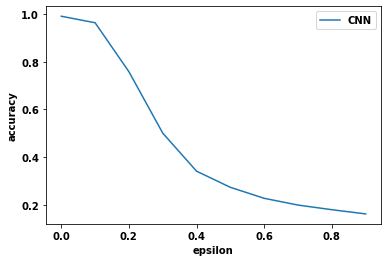

In [22]:
xdata.plot(label="CNN")
plt.legend()

Now, instead of executing the task per model, we can take advantage of `multirun` to get the curve metrics for each of our trained models.  Here our task function returns a `xarray.DataArray`.

In [23]:
def curve_task_fn(cfg):
    task = TranslationRobustness(cfg)
    task.run(job_epsilons=cfg.job_epsilon)
    print("Finished Job")
    print("")
    return task.to_xarray()


(curve_jobs,) = launch(
    Config,
    curve_task_fn,
    overrides=["model=trained_fc,trained_cnn", "+job_epsilon='range(0,1,0.1)'",],
    multirun=True,
)

[2022-03-10 22:38:09,880][HYDRA] Launching 2 jobs locally
[2022-03-10 22:38:09,880][HYDRA] 	#0 : model=trained_fc +job_epsilon='range(0,1,0.1)'
[2022-03-10 22:38:10,641][HYDRA] Launching 10 jobs locally
[2022-03-10 22:38:10,641][HYDRA] 	#0 : epsilon=0.0
[2022-03-10 22:38:11,389][HYDRA] 	#1 : epsilon=0.1
[2022-03-10 22:38:12,193][HYDRA] 	#2 : epsilon=0.2
[2022-03-10 22:38:12,953][HYDRA] 	#3 : epsilon=0.3
[2022-03-10 22:38:13,786][HYDRA] 	#4 : epsilon=0.4
[2022-03-10 22:38:14,554][HYDRA] 	#5 : epsilon=0.5
[2022-03-10 22:38:15,413][HYDRA] 	#6 : epsilon=0.6
[2022-03-10 22:38:16,234][HYDRA] 	#7 : epsilon=0.7000000000000001
[2022-03-10 22:38:17,004][HYDRA] 	#8 : epsilon=0.8
[2022-03-10 22:38:17,978][HYDRA] 	#9 : epsilon=0.9
Finished Job

[2022-03-10 22:38:18,857][HYDRA] 	#1 : model=trained_cnn +job_epsilon='range(0,1,0.1)'
[2022-03-10 22:38:19,644][HYDRA] Launching 10 jobs locally
[2022-03-10 22:38:19,644][HYDRA] 	#0 : epsilon=0.0
[2022-03-10 22:38:20,522][HYDRA] 	#1 : epsilon=0.1
[2022-03-1

We `concat` the outputs into a new `xarray.DataArray` and plot the results.

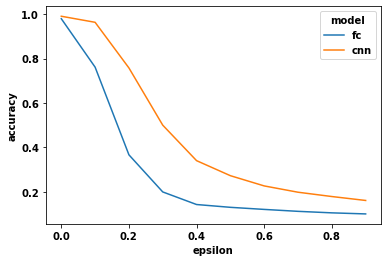

In [24]:
exp_inds = ["cnn", "dnn"]
exp_coord = xr.DataArray(["fc", "cnn"], name="model", dims=["model"], coords=[exp_inds])
xdata = xr.concat(([c.return_value for c in curve_jobs]), exp_coord)
xdata.plot.line(x="epsilon")

Take-Aways:

- Domain Knowledge: CNNs model translation equivariance into the model, an inductive bias based on domain knowledge.
- Robustness: CNNs are more robust to unseen translations than a linear network.
- Complexity: CNNs are less complex (less parameters) than linear networks.
- Sample Efficient: CNNs acheive top performance metrics with less data.

## Data Augmentations

While we showed that the convolution property of translation equivariance leads to more robust models, we still saw a drop in performance. What if we also augment the dataset with some random translation and train both the CNN and FC models. Here we train with an random translation parameter $\epsilon = 0.2$

In [25]:
(aug_training_jobs,) = launch(
    Config,
    train_task_fn,
    overrides=["model=cnn,fc", "trainer.device=cuda", "epsilon=0.2"],
    multirun=True,
)

[2022-03-10 22:38:37,494][HYDRA] Launching 2 jobs locally
[2022-03-10 22:38:37,494][HYDRA] 	#0 : model=cnn trainer.device=cuda epsilon=0.2


  0%|          | 0/10 [00:00<?, ?it/s]

[2022-03-10 22:39:02,016][HYDRA] 	#1 : model=fc trainer.device=cuda epsilon=0.2


  0%|          | 0/10 [00:00<?, ?it/s]

As we did above, create new configs with the checkpoint stored for experimentation.

In [28]:
AugTrainedConvModelCfg = make_config(
    ckpt=Path(aug_training_jobs[0].working_dir).absolute() / "model.ckpt",
    nn=_ConvModelCfg,
    hydra_convert="all",
)
AugTrainedLinearModelCfg = make_config(
    ckpt=Path(aug_training_jobs[1].working_dir).absolute() / "model.ckpt",
    nn=_LinearModelCfg,
    hydra_convert="all",
)

cs.store(name="aug_trained_cnn", group="model", node=AugTrainedConvModelCfg)
cs.store(name="aug_trained_fc", group="model", node=AugTrainedLinearModelCfg)

First lets update the bar chart for an easy comparison.

[2022-03-10 22:39:32,931][HYDRA] Launching 2 jobs locally
[2022-03-10 22:39:32,931][HYDRA] 	#0 : model=aug_trained_cnn epsilon=0
[2022-03-10 22:39:34,034][HYDRA] 	#1 : model=aug_trained_cnn epsilon=0.2
[2022-03-10 22:39:35,563][HYDRA] Launching 2 jobs locally
[2022-03-10 22:39:35,564][HYDRA] 	#0 : model=aug_trained_fc epsilon=0
[2022-03-10 22:39:36,421][HYDRA] 	#1 : model=aug_trained_fc epsilon=0.2


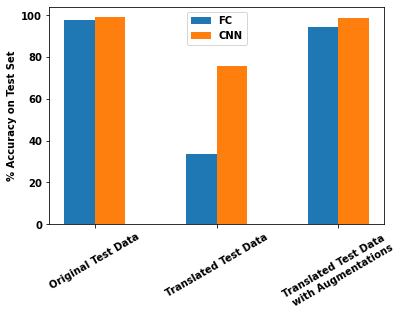

In [29]:
(aug_cnn_tests,) = launch(
    Config,
    testing_task_fn,
    overrides=["model=aug_trained_cnn", "epsilon=0,0.2",],
    multirun=True,
)

(aug_fc_tests,) = launch(
    Config,
    testing_task_fn,
    overrides=["model=aug_trained_fc", "epsilon=0,0.2",],
    multirun=True,
)

bar_chart(cnn_tests, fc_tests, aug_cnn_tests, aug_fc_tests)

Now generate the robustness curves for the new models.

In [30]:
(aug_curve_jobs,) = launch(
    Config,
    curve_task_fn,
    overrides=[
        "model=aug_trained_fc,aug_trained_cnn",
        "+job_epsilon='range(0,1,0.1)'",
    ],
    config_name="robustness_curve",
    multirun=True,
)

[2022-03-10 22:39:37,757][HYDRA] Launching 2 jobs locally
[2022-03-10 22:39:37,758][HYDRA] 	#0 : model=aug_trained_fc +job_epsilon='range(0,1,0.1)'
[2022-03-10 22:39:38,545][HYDRA] Launching 10 jobs locally
[2022-03-10 22:39:38,546][HYDRA] 	#0 : epsilon=0.0
[2022-03-10 22:39:39,359][HYDRA] 	#1 : epsilon=0.1
[2022-03-10 22:39:40,098][HYDRA] 	#2 : epsilon=0.2
[2022-03-10 22:39:40,880][HYDRA] 	#3 : epsilon=0.3
[2022-03-10 22:39:41,693][HYDRA] 	#4 : epsilon=0.4
[2022-03-10 22:39:42,508][HYDRA] 	#5 : epsilon=0.5
[2022-03-10 22:39:43,329][HYDRA] 	#6 : epsilon=0.6
[2022-03-10 22:39:44,175][HYDRA] 	#7 : epsilon=0.7000000000000001
[2022-03-10 22:39:44,980][HYDRA] 	#8 : epsilon=0.8
[2022-03-10 22:39:45,833][HYDRA] 	#9 : epsilon=0.9
Finished Job

[2022-03-10 22:39:46,667][HYDRA] 	#1 : model=aug_trained_cnn +job_epsilon='range(0,1,0.1)'
[2022-03-10 22:39:47,641][HYDRA] Launching 10 jobs locally
[2022-03-10 22:39:47,642][HYDRA] 	#0 : epsilon=0.0
[2022-03-10 22:39:48,501][HYDRA] 	#1 : epsilon=0.1
[2

In [32]:
exp_coord = xr.DataArray(
    ["aug fc", "aug cnn"], name="model", dims=["model"], coords=[exp_inds]
)
aug_xdata = xr.concat(([c.return_value for c in aug_curve_jobs]), exp_coord)
all_xdata = xr.concat((xdata, aug_xdata), dim="model")
all_xdata.to_dataframe()

accuracy
model   epsilon          
fc      0.0        0.9799
        0.1        0.7617
        0.2        0.3668
        0.3        0.1997
        0.4        0.1430
        0.5        0.1304
        0.6        0.1210
        0.7        0.1123
        0.8        0.1055
        0.9        0.1007
cnn     0.0        0.9910
        0.1        0.9637
        0.2        0.7581
        0.3        0.5004
        0.4        0.3406
        0.5        0.2729
        0.6        0.2268
        0.7        0.1984
        0.8        0.1790
        0.9        0.1613
aug fc  0.0        0.9579
        0.1        0.9565
        0.2        0.9473
        0.3        0.8205
        0.4        0.5409
        0.5        0.3864
        0.6        0.2925
        0.7        0.2327
        0.8        0.1969
        0.9        0.1692
aug cnn 0.0        0.9852
        0.1        0.9873
        0.2        0.9865
        0.3        0.9457
        0.4        0.7668
        0.5        0.5702
        0.6        0.4373
        0.7        0.3523
        0.8        0.2952
        0.9        0.2444

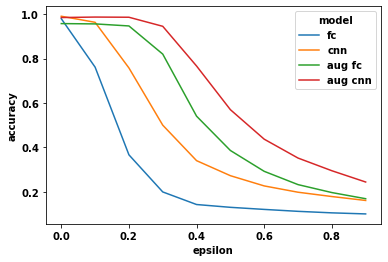

In [33]:
all_xdata.plot.line(x="epsilon")